# Chapter 3: Classification

## MNIST

In [0]:
# Downloading the MNIST data.

from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sorted_indices = np.argsort(mnist.target)
mnist.data = mnist.data[sorted_indices]
mnist.target = mnist.target[sorted_indices]
print(mnist)

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8), 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pix

In [0]:
# Examining the downloaded data.

X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


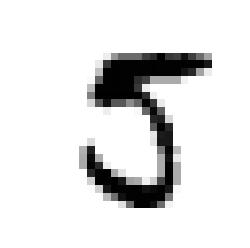

In [0]:
# Plotting an image in the dataset.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

In [0]:
# The label should be "9".

print(y[36000])

5


In [0]:
# Split the data into training and test sets.

shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [0]:
# To simplify the problem, let's first train a classifier to see if a handwritten digit is a "5".

y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [0]:
# Starting with the Stochastic Gradient Descent classifier.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict([some_digit]))

[ True]


## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation

In [0]:
# Implementation of a function which is similar to sklearn's cross_val_score().

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.8723627637236276
0.88615
0.8917391739173918


In [0]:
# Using cross_val_score to measure the performance of the SGDClassifier.

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9481 , 0.96385, 0.96675])

In [0]:
# The results look promising, however it is because the dataset is not
# balanced, 90% of the samples are false. To illustrate this, we implement
# a classifier which always returns false. This illustrates that accuracy
# is not always the best performance metric.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9074 , 0.91325, 0.90875])

### Confusion Matrix

In [0]:
# Uses cross_val_predict to get predictions from cross-validation.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [0]:
# Computes the confusion matrix from this cross-validation analysis.
# Confusion matrix:
#  TN FN
#  FP TP

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53238,  1350],
       [ 1216,  4196]])

### Precision and Recall

#### Equation for Precision:

$p = \large{\frac{TP}{TP\;+\;FP}}$

which shows how many positive predictions were correct.

#### Equation for Recall:

$r = \large{\frac{TP}{TP\;+\;FN}}$

which shows how what percentage of all positive cases were detected.

In [0]:
# After computing the precision and recall, we see the SGDClassifier is not as good as the
# accuracy metric would lead you to believe.

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7565813198701767
0.7753141167775314


#### Equation for F1 score:

$ F_1 = \large{\frac{1}{\frac{1}{p} + \frac{1}{r}}} = \small{2\;\times\;}\large{\frac{p\;\times\;r}{p\;+\;r}}
= \large{\frac{TP}{TP\;+\;\frac{FN\;+\;FP}{2}}} $

$F_1$ score is the harmonic mean of the precision and recall. If one of the values are low, the mean will favor
that low value.

In [0]:
# Scikit-Learn provides a utility function for computing F1 score.

from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7658331812374521


### Precision/Recall Tradeoff

In [0]:
# There is generally a tradeoff between precision and recall. You can
# increase precision by increasing the threshold needed to classify a
# sample as positive, but this hurts recall. Conversely you could make
# the threshold more lax, increasing recall but hurting precision.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[5911.79862363]
[ True]
[False]


In [0]:
# Now we have cross_val_predict return the decision scores instead of predictions.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [0]:
# Now it is possible to compute precision and recall for all possible threshold values
# using Scikit-Learn's precision_recall_curve().

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

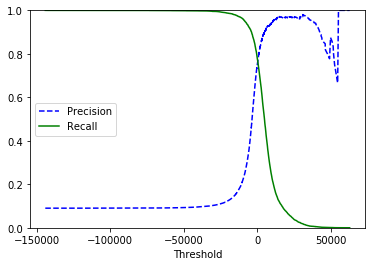

In [0]:
# Plots the precision and recall as functions of the threshold.

def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

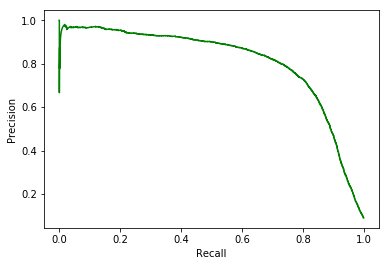

In [0]:
# You can also plot precision as a function of recall to gain insights.

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'g-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

The _receiver operating characteristic_ (ROC) curve is a plot of the true positive rate (TPR or recall)
as a function of the false positive rate (FPR)

#### Equation for FPR:

$ FPR \; = \large{\frac{FP}{TN\;+\;FP}} $

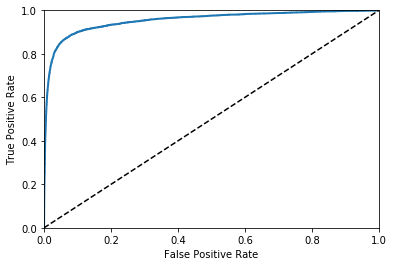

In [0]:
# Plotting the ROC curve using Scikit-Learn. The dotted line represents a purely
# random classifier.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
# One way to measure the performance of a classifier is to compute the area under curve (AUC)
# of the ROC function. A random classifier would have an AUC of 0.5 and a perfect classifier
# would have an AUC of 1.

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9540328530196311

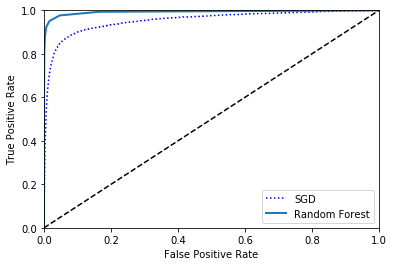

In [0]:
# Training a RandomForestClassifier and compare its ROC curve to the
# SGDClassifier.

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

y_scores_forest = y_probas_forest[:, -1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [0]:
# Also display the ROC AUC score of the RandomForestClassifier.

roc_auc_score(y_train_5, y_scores_forest)

0.9928375260927913

## Multiclass Classification

In [0]:
# By default, most classifiers in Scikit-Learn use the one-versus-all (OvA) strategy with binary classifiers
# for multiclass problems. Support vector machines are more efficient with small datasets, so Scikit-Learn
# defaults to the one-versus-other (OvO) strategry.

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [0]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31209.97174714, -32988.17693244, -17248.34586908,
        -13012.54523543, -36430.72811706,   5911.79862363,
        -71850.22116416,  -1718.74659128,  -4147.96316929,
         -8167.19638067]])

In [0]:
# Displays that 5 had the best decision function score of any digit, which is expected.

print(sgd_clf.classes_)
print(sgd_clf.classes_[np.argmax(some_digit_scores)])

[0 1 2 3 4 5 6 7 8 9]
5


In [0]:
# The sklearn.multiclass has a OneVsOne classes which wrap classifiers and specify a specific
# strategy to use for multiclass classification.

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [0]:
# We can also train a RandomForestClassifier, which are multiclass classifiers by design and
# do not use OvO or OvA.

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [0]:
# We can display the classifier's determined probabilities that the sample is
# a member of each class.

forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1, 0. ]])

In [0]:
# We can also get a sense of the model's performance using cross-validation.

cross_val_score(sgd_clf, X_train, y_train, cv=3,
               scoring='accuracy')

array([0.87451255, 0.8744    , 0.8719872 ])

In [0]:
# StandardScaler can improve the accuracy of this model.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
               scoring='accuracy')

/home/dylan_james_cutler/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89731027, 0.8965    , 0.90639064])

## Error Analysis

In [0]:
# Produces the confusion matrix of the SGDClassifier.

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/dylan_james_cutler/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5589,    0,   14,    7,   11,   41,   34,    7,  211,    1],
       [   1, 6448,   47,   19,    3,   43,    9,    6,  187,   11],
       [  24,   29, 5269,   88,   66,   22,   67,   42,  368,   11],
       [  21,   18,  118, 5237,    0,  202,   21,   44,  395,   64],
       [   8,   13,   49,    7, 5211,   11,   35,   24,  321,  153],
       [  29,   17,   25,  159,   50, 4484,   78,   18,  484,   68],
       [  28,   16,   46,    1,   45,   88, 5540,    5,  139,    0],
       [  22,   12,   70,   30,   45,   14,    4, 5681,  157,  219],
       [  20,   53,   49,   87,    6,  140,   34,    7, 5387,   49],
       [  23,   24,   26,   57,  135,   45,    1,  179,  319, 5158]])

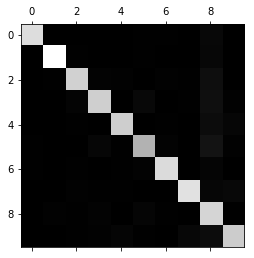

In [0]:
# Plotting the confusion matrix. Each row represents the actual class of each sample
# and each column is the predicted class.

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

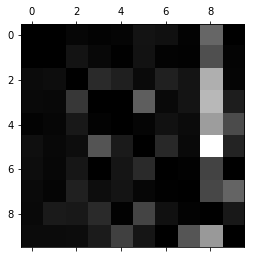

In [0]:
# You can divide each cell by the sum of each sample in each class. This way
# you get a good picture of what kind of errors the classifier makes. You
# can see that fives get mischaracterized as 8's often.

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

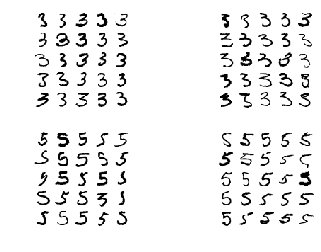

In [0]:
# Plotting some examples of when the classifier was correct and when
# it made an error.

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [0]:
# Train a KNeighborsClassifier to predict if a number is large (7, 8, 9)
# and/or is odd.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = ((y_train & 1) == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [0]:
# Test the classifier with the sample taken above. It correctly classifies
# the number as less than 7 and odd.

knn_clf.predict([some_digit])

array([[False,  True]])

In [0]:
# Displays the F1 score of this classifier.

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average=None)

array([0.97098463, 0.98240369])

## Multioutput Classification

In [0]:
# Training a classifier to reduce noise in the images of the digits. This classifier
# is both multilabel (assigns one class per pixel) and multiclass (each pixel is given
# an integer value between 0 and 255). This makes this classifier a multioutput classifier.

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

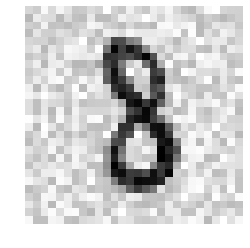

In [0]:
# Displaying a noisy digit from the test set, normally you do not snoop
# on the test set.

some_index = 1400

def plot_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary,
               interpolation='nearest')
    plt.axis('off')
    plt.show()

plot_digit(X_test_mod[some_index])

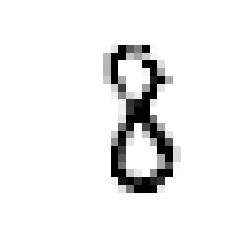

In [0]:
# The same digit after the model removes the noise it finds.

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercises

### Exercise 1:
Create a classifier for the MNIST dataset which achieves over 97% accuracy on the test set.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'n_neighbors': range(4, 7),
    'weights': ['uniform', 'distance']
}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

print(grid_search.best_estimator_.score(X_test, y_test))

This cell is taking hours to compile since it has to train 180 binary classifiers.
The solution is `n_neighbors=4` and `weights='distance'`.

In [1]:
# Email notification lets me know when it is done.
# This is useful for Google Colab since the output won't be saved
# if the VM that runs this job goes idle I will lose the output.

# This will only work in Google colab where I am logged in.

import smtplib

def notify(msg):
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login("<username>@gmail.com", "<password>")
    server.sendmail(
        "<username>@gmail.com",
        "<username>@gmail.com", 
        'SUBJECT: Colab\n\n' + str(msg))
    server.quit()

In [4]:
# Clock class for measuring the execution time of training models.

import time

class Clock:
  def __init__(self):
    self.start_time = None
  def start(self):
    self.start_time = time.time()
    return self
  def stop(self):
    dt = time.time() - self.start_time
    self.start_time = None
    h, m, s = int(dt // 3600), int(dt % 3600) // 60, dt % 60
    return '{}h {}m {:.3f}s'.format(h, m, s)

In [0]:
# AS you can see with this setting, we achieve over 97% accuracy on the test set.

from sklearn.neighbors import KNeighborsClassifier

c = Clock().start()

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train, y_train)
score = knn_clf.score(X_test, y_test)
print(score)

notify('Accuracy: {:.6f} Elapsed Time: {}'.format(
        score, c.stop()))

0.9768


### Exercise 2

Write a function that can shift an MIST function in any direction:

In [0]:
from scipy.ndimage.interpolation import shift

shift_digit = lambda digit, dx, dy: \
    shift(digit.reshape(28, 28), [dy, dx], cval=0).flatten()

Train the classifier defined above using a training set comprised of the original training set, and a copy of each digit shifted one pixel in each cadinal direction.

In [46]:
c = Clock().start()

X_train_shifted = [img for img in X_train]
y_train_shifted = [label for label in y_train]

for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
    for digit, label in zip(X_train, y_train):
        X_train_shifted.append(shift_digit(digit, dx, dy))
        y_train_shifted.append(label)
        
knn_clf.fit(X_train_shifted, y_train_shifted)
score = knn_clf.score(X_test, y_test)
print(score)

notify(
    'Accuracy: {:.6f} Elapsed Time: {}'.format(
        score, c.stop()))

0.9832


This model took over an hour to train due to the size of the training set. But it achieved over 98% accuracy on the test set.